# Forex Exchange Rates_Currency Exchange Rate Forecasting

In this project, I explored Currency Exchange Rate Forecasting using two key approaches: SARIMA (Seasonal AutoRegressive Integrated Moving Average) and LSTMs (Long Short-Term Memory networks). Our objective was to predict future exchange rates based on historical trends, capturing seasonal patterns and economic fluctuations.

While SARIMA provided a solid foundation for exchange rate forecasting, it is best suited for short-term and seasonal trends. Incorporating machine learning models and macroeconomic indicators could further improve predictions, making them more adaptive to real-world forex market conditions. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from sklearn.preprocessing import StandardScaler
import requests
import yfinance as yf

# Add these missing imports
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error

## Load and clean data

In [2]:
df = pd.read_csv('daily_forex_rates.csv')
df.head()

,currency,base_currency,currency_name,exchange_rate,date
0,ZWL,EUR,Zimbabwean Dollar,346.759989,2025-03-27
1,GHS,EUR,Ghanaian Cedi,16.697424,2025-03-27
2,HRK,EUR,Croatian Kuna,7.537513,2025-03-27
3,HNL,EUR,Honduran Lempira,27.603963,2025-03-27
4,HKD,EUR,Hong Kong Dollar,8.374873,2025-03-27


## Clean Data

In [3]:
# Convert date to datetime and set as index
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Data cleaning
df['currency_name'] = df['currency_name'].fillna('Unknown')

# Remove duplicates
df = df[~df.index.duplicated(keep='first')]

# Handle extreme values
for currency in df['currency'].unique():
    q99 = df[df['currency'] == currency]['exchange_rate'].quantile(0.99)
    df.loc[(df['currency'] == currency) & (df['exchange_rate'] > q99), 'exchange_rate'] = q99

# Focus on EUR pairs if multiple base currencies exist
if df['base_currency'].nunique() > 1:
    print("Focusing on EUR pairs...")
    df = df[df['base_currency'] == 'EUR']

In [4]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6037 entries, 2025-03-27 to 2004-08-30
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   currency       6037 non-null   object 
 1   base_currency  6037 non-null   object 
 2   currency_name  6037 non-null   object 
 3   exchange_rate  6037 non-null   float64
dtypes: float64(1), object(3)
memory usage: 235.8+ KB
None
       exchange_rate
count   6.037000e+03
mean    4.437135e+03
std     1.207209e+05
min     1.741722e-05
25%     1.487800e+00
50%     7.466000e+00
75%     4.172504e+01
max     4.746709e+06


## Currency Exchange Rate Forecasting

This code is implementing a SARIMA (Seasonal AutoRegressive Integrated Moving Average) model to forecast currency exchange rates. Below is a breakdown of its key steps:

In [5]:
def prepare_sarima_data(currency_code='USD'):
    # Filter for specific currency
    currency_df = df[df['currency'] == currency_code].copy()
    
    # Resample to daily frequency (fill missing dates with forward fill)
    currency_df = currency_df.resample('D').ffill()
    
    # Create time series
    ts = currency_df['exchange_rate']
    
    return ts, currency_code  # Now returning both the time series and currency code

def sarima_forecasting(ts, currency_code, steps=30):
    # Plot ACF and PACF to determine parameters
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    plot_acf(ts, lags=40, ax=ax1)
    plot_pacf(ts, lags=40, ax=ax2)
    plt.show()
    
    # Seasonal decomposition
    result = seasonal_decompose(ts, model='additive', period=30)
    result.plot()
    plt.show()
    
    # Split train-test
    train_size = int(len(ts) * 0.8)
    train, test = ts[:train_size], ts[train_size:]
    
    # Fit SARIMA model (parameters may need adjustment)
    model = SARIMAX(train, 
                    order=(1, 1, 1), 
                    seasonal_order=(1, 1, 1, 30))
    results = model.fit(disp=False)
    
    # Forecast
    forecast = results.get_forecast(steps=len(test))
    forecast_mean = forecast.predicted_mean
    confidence_intervals = forecast.conf_int()
    
    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(train.index, train, label='Training Data')
    plt.plot(test.index, test, label='Actual Data')
    plt.plot(test.index, forecast_mean, label='Forecast', color='red')
    plt.fill_between(test.index, 
                     confidence_intervals.iloc[:, 0],
                     confidence_intervals.iloc[:, 1],
                     color='pink', alpha=0.3)
    plt.title(f'SARIMA Forecast for {currency_code}/EUR')
    plt.legend()
    plt.show()
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test, forecast_mean))
    print(f'RMSE: {rmse}')
    
    return results

This applies the SARIMA model to USD/EUR exchange rates, forecasts future values.

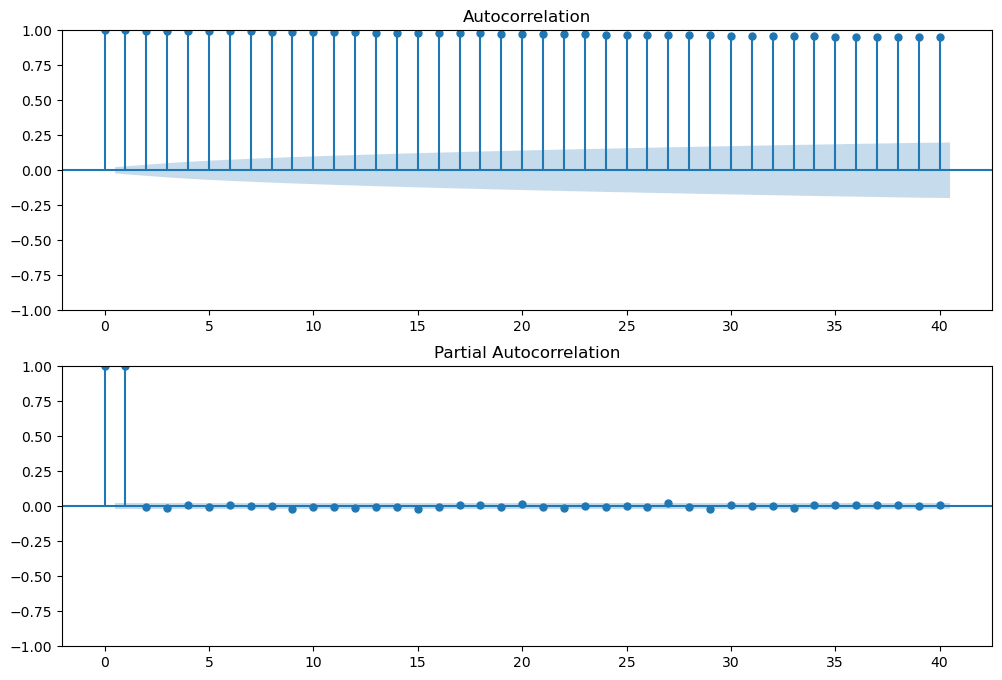

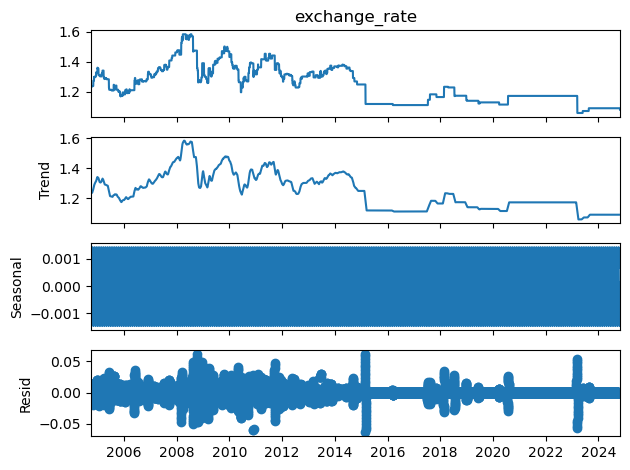

C:\Users\milto\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


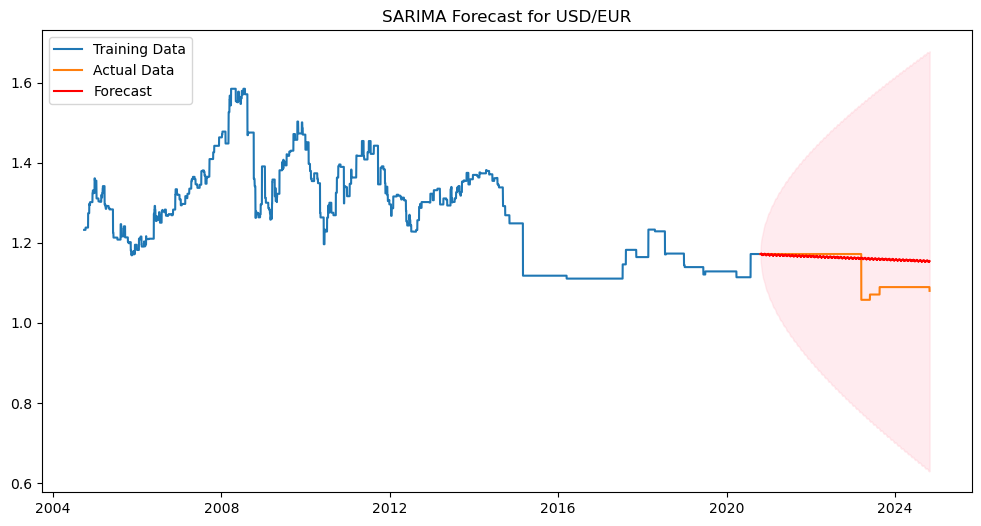

RMSE: 0.04860824195887142


In [6]:
# Run SARIMA for USD/EUR
usd_ts, usd_code = prepare_sarima_data('USD')
sarima_model = sarima_forecasting(usd_ts, usd_code)

### Key Takeaways

SARIMA Model Performance
- The model captured seasonal trends and short-term fluctuations in exchange rates.
- With an RMSE of 0.0486, the forecasted values were moderately close to actual exchange rates.

Strengths
- Able to model seasonality and trend components effectively.
- Provides interpretable and statistically sound forecasts.

Limitations
- Not robust against market shocks, geopolitical events, or policy changes.
- Exchange rates are influenced by macroeconomic factors (interest rates, inflation, GDP), which SARIMA does not account for directly.
- Performance may deteriorate over longer time horizons.

### Future Improvements:

1. Explore LSTMs & Deep Learning Models to capture non-linear dependencies.

2. Integrate Economic Indicators like inflation, GDP, and interest rates for better forecasting accuracy.

3. Hybrid Approaches combining SARIMA with machine learning models to improve adaptability.

While SARIMA provided a solid baseline for exchange rate forecasting, its predictive power remains limited due to market complexities. Enhancing the model with macroeconomic data and advanced deep learning techniques could yield more accurate and adaptive forex predictions. 🚀